**Sriram Sunderrajan** <br>
**220962444** <br>
**Deep Learning Lab - Week 8** <br>
**Recurrent Neural Network** <br>
**CSE - AIML (A2 - 77)** <br>
**18th March 2025** <br><br>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
import os
from PIL import Image

## Question - 1

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("joebeachcapital/natural-gas-prices")

print("Path to dataset files:", path)

In [8]:
csv_path = "./Data/Natural Gas/daily_csv.csv"

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
df = pd.read_csv(csv_path)

# Preprocess the data - Drop NA values in the dataset
df = df.dropna()

y = df['Price'].values
x = np.arange(1, len(y), 1)

print(len(y))

# Normalize the input range between 0 and 1
minm = y.min()
maxm = y.max()
print(minm, maxm)

y = (y - minm) / (maxm - minm)

Sequence_Length = 10
X = []
Y = []

for i in range(0, 5900):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
        X.append(list1)
        Y.append(y[j + 1])
        
#Convert from list to array
X = np.array(X)
Y = np.array(Y)

#Split the data as the train and test set
x_train, x_test, y_train, y_test = train_test_split(X, Y,
test_size=0.10, random_state=42, shuffle=False, stratify=None)

5952
1.05 18.48


In [21]:
class NGT(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx].to(device), self.y[idx].to(device)

    def __len__(self):
        return self.len

dataset = NGT(x_train,y_train)

from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, shuffle=True, batch_size=256)

In [22]:
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel,self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        output, _status = self.rnn(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

In [23]:
model = RNNModel().to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 1500

for i in range(1, epochs+1):
    for j, data in enumerate(train_loader):
        y_pred = model(data[:][0].view(-1, Sequence_Length, 1)).reshape(-1)
        loss = criterion(y_pred, data[:][1])
        loss.backward()
        optimizer.step()
    if i % 50 == 0:
        print(i, "th iteration : ", loss)

50 th iteration :  tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

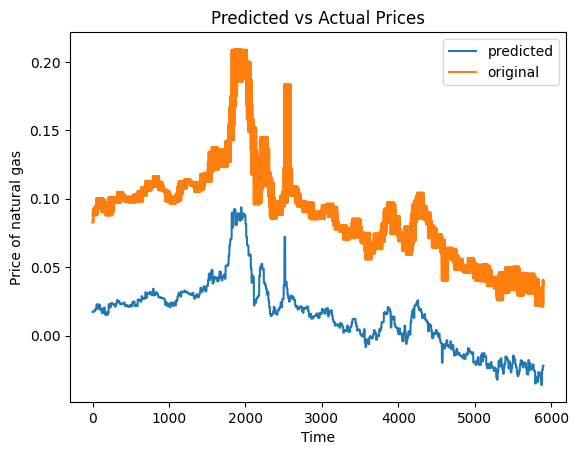

'\n#Undo normalization\ny = y * (maxm - minm) + minm\ny_pred = test_pred.detach().cpu().numpy() * (maxm - minm) + minm\n\nplt.plot(y)\nplt.plot(range(len(y)-len(y_pred), len(y)), y_pred)\nplt.show()\n'

In [31]:
# Test actual vs predicted
test_set = NGT(x_test,y_test)
test_pred = model(test_set[:][0].view(-1,10,1)).view(-1)

plt.title("Predicted vs Actual Prices")
plt.xlabel("Time")
plt.ylabel("Price of natural gas")
plt.plot(test_pred.detach().cpu().numpy(), label='predicted')
plt.plot(test_set[:][1].view(-1).cpu(), label='original')
plt.legend()
plt.show()


"""
#Undo normalization
y = y * (maxm - minm) + minm
y_pred = test_pred.detach().cpu().numpy() * (maxm - minm) + minm

plt.plot(y)
plt.plot(range(len(y)-len(y_pred), len(y)), y_pred)
plt.show()
"""

## Question - 2

In [158]:
from glob import glob
import random
import string

names_dir_path = "./Data/Names/data/names/"

class namesDataset(Dataset):
    def __init__(self, dir, train_split=0.9, max_length=None):
        super().__init__()
        
        self.train = True
        self.data = []
        
        self.labelToLang = {}
        
        # Mapping of characters to integers
        all_characters = string.ascii_lowercase
        self.n_characters = len(all_characters)
        self.char_to_index = {ch: i for i, ch in enumerate(all_characters)}
        
        file_names = glob(os.path.join(dir, "*.txt"))
            
        
        for lang_idx, file_name in enumerate(file_names):
            lang = file_name.split("/")[-1][:-4]
            self.labelToLang[lang_idx] = lang
            
            f = open(file_name, "r")
            self.data += [([self.char_to_index.get(ch, 0) for ch in name[:-1].lower()], lang_idx) for name in f.readlines()]
        
        self.max_length = max_length
        
        if self.max_length is None:
            self.max_length = max([len(data_point[0]) for data_point in self.data])
        
        random.shuffle(self.data)
        # print(self.data)
        
        self.train_data, self.test_data = self.data[:int(len(self.data) * train_split)], self.data[int(len(self.data) * train_split):]
        print(len(self.train_data), len(self.test_data))
        print(self.test_data)
    
    def __len__(self):
        return len(self.train_data) if self.train else len(self.test_data)
    
    def __getitem__(self, idx):
        name, label = self.train_data[idx] if self.train else self.test_data[idx]
        
        # Pad name to have fixed length
        name = name[:self.max_length] + [0] * (self.max_length - len(name))
        
        return torch.Tensor(name).to(device), torch.tensor(label).to(device)

In [159]:
dataset = namesDataset(names_dir_path)

18066 2008
[([11, 4, 13, 8, 7, 0, 13], 17), ([3, 0, 7, 4, 17], 5), ([6, 8, 13, 19, 24], 17), ([17, 14, 1, 0, 10, 8, 3, 25, 4], 1), ([7, 20, 1, 20, 19, 8, 24, 0], 1), ([9, 0, 2, 7, 13, 8, 10], 1), ([0, 19, 24, 0, 18, 14, 21], 1), ([11, 8, 13, 6], 3), ([12, 20, 25, 7, 25, 7, 0, 21, 11, 4, 21], 1), ([6, 0, 20, 17], 1), ([21, 8, 11, 24, 20, 13, 0, 18], 1), ([6, 7, 0, 13, 4, 12], 5), ([9, 8, 3, 10, 14, 21], 1), ([24, 0, 12, 0, 14, 10, 0], 7), ([11, 8, 2, 7, 10, 20, 13], 1), ([14, 18, 19, 11, 4, 17], 17), ([13, 14, 19, 14, 17, 8, 0, 13, 14], 14), ([24, 4, 19, 12, 0, 13], 17), ([1, 0, 25], 5), ([18, 0, 11, 8, 13, 0, 18], 11), ([0, 2, 16, 20, 0], 14), ([18, 8, 11, 21, 4, 18, 19, 17, 8], 14), ([17, 14, 12, 15, 0, 24, 4], 9), ([17, 14, 12, 0, 6, 13, 14, 11, 8], 14), ([18, 7, 0, 13, 0, 20, 17, 8, 13], 1), ([7, 0, 15, 24], 1), ([3, 14, 21, 4, 8, 10, 14], 1), ([5, 0, 10, 7, 14, 20, 17, 24], 5), ([18, 19, 0, 1, 8, 11, 4], 14), ([11, 24, 19, 10, 8, 13, 0], 1), ([24, 0, 13, 10, 8, 18], 1), ([15, 0, 24

In [199]:
train_loader = DataLoader(dataset, shuffle=False, batch_size=32)
test_loader = DataLoader(dataset, shuffle=True, batch_size=16)

In [200]:
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [201]:
name = [9, 0, 17, 12, 0, 13]

dct = {}
dct_ = dataset.char_to_index
for i in dct_:
    dct[dct_[i]] = i

"".join([dct[i] for i in name])

'jarman'

In [202]:
dataset.labelToLang

{0: 'French',
 1: 'Russian',
 2: 'Scottish',
 3: 'Chinese',
 4: 'Czech',
 5: 'Arabic',
 6: 'Korean',
 7: 'Japanese',
 8: 'Vietnamese',
 9: 'Dutch',
 10: 'Greek',
 11: 'Spanish',
 12: 'Irish',
 13: 'German',
 14: 'Italian',
 15: 'Polish',
 16: 'Portuguese',
 17: 'English'}

In [203]:
n_characters = dataset.n_characters
n_languages = len(dataset.labelToLang)

n_characters, n_languages

(26, 18)

In [204]:
class LanguageModel(nn.Module):
    def __init__(self, n_characters=n_characters, n_languages=n_languages, hidden_size=5):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(n_characters, hidden_size)
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, num_layers=5, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_languages)

    def forward(self, x):
        # x = self.embedding(x)  # [batch_size, seq_len, hidden_size]
        out, _ = self.rnn(x)  # Get the RNN output
        # print(out.size(), out)
        out = out[:, -1, :]  # Take the output of the last time step
        # print(out.size(), out)
        out = self.fc(out)  # Final linear layer for classification
        return out

In [205]:
# Initialize the model, loss function, and optimizer

learning_rate = 1e-2

model = LanguageModel(n_characters=n_characters, n_languages=n_languages).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [206]:
# Training loop
dataset.train = True
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for names, labels in train_loader:
        # Zero gradients
        optimizer.zero_grad()
        
        names = names.unsqueeze(2)
        # labels = labels.unsqueeze(0)
        
        # Forward pass
        outputs = model(names)
        
        # print(labels.size(), outputs.size())
        # outputs = nn.functional.softmax(outputs, dim=1)
        
        # Compute loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track accuracy
        _, predicted = torch.max(y_pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # print(predicted, labels)
    
    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/10], Loss: 1.8757, Accuracy: 46.80%
Epoch [2/10], Loss: 1.8524, Accuracy: 46.80%
Epoch [3/10], Loss: 1.8525, Accuracy: 46.80%
Epoch [4/10], Loss: 1.8525, Accuracy: 46.80%
Epoch [5/10], Loss: 1.8525, Accuracy: 46.80%
Epoch [6/10], Loss: 1.8526, Accuracy: 46.80%
Epoch [7/10], Loss: 1.8526, Accuracy: 46.80%
Epoch [8/10], Loss: 1.8525, Accuracy: 46.80%
Epoch [9/10], Loss: 1.8525, Accuracy: 46.80%
Epoch [10/10], Loss: 1.8522, Accuracy: 46.80%


In [208]:
dataset.train = False

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for names, labels in test_loader:
        names = names.unsqueeze(2)
        outputs = model(names)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 47.51%


In [214]:
with torch.no_grad():
    for i in range(50):
        name, label = dataset[i]
        name, label = torch.unsqueeze(name, 0), torch.unsqueeze(label, 0)
        name = name.unsqueeze(2)
        #print(name, label)
        outputs = model(name)
        _, predicted = torch.max(outputs, 1)
        # print(predicted)

        print("Actual:", dataset.labelToLang[label.detach().cpu().item()])
        print("Predicted:", dataset.labelToLang[predicted.detach().cpu().item()])
        print()

Actual: English
Predicted: Russian

Actual: Arabic
Predicted: Russian

Actual: English
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Chinese
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Arabic
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Japanese
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: English
Predicted: Russian

Actual: Italian
Predicted: Russian

Actual: English
Predicted: Russian

Actual: Arabic
Predicted: Russian

Actual: Spanish
Predicted: Russian

Actual: Italian
Predicted: Russian

Actual: Italian
Predicted: Russian

Actual: Dutch
Predicted: Russian

Actual: Italian
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Russian
Predicted: Russian

Actual: Arabic
Predicted: Russia

## Question - 3

In [218]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import string

# Step 1: Prepare the data
text = "Hello, this is a simple next character predictor. Try it out!"

# Create a set of all unique characters in the text
chars = sorted(set(text))
vocab_size = len(chars)
char_to_index = {ch: i for i, ch in enumerate(chars)}
index_to_char = {i: ch for i, ch in enumerate(chars)}

# Convert the text into numerical indices
encoded_text = [char_to_index[ch] for ch in text]

# Define sequence length (how many characters to look back to predict the next)
sequence_length = 10

# Prepare input-output pairs for training (X, y)
X = []
y = []

for i in range(len(encoded_text) - sequence_length):
    X.append(encoded_text[i:i + sequence_length])
    y.append(encoded_text[i + sequence_length])

X = torch.tensor(X)
y = torch.tensor(y)

# Step 2: Define the RNN model
class NextCharacterRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NextCharacterRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        
        # Pass input through RNN layer
        out, hn = self.rnn(x, h0)
        
        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        
        return out

# Hyperparameters
input_size = vocab_size  # One-hot encoding of each character
hidden_size = 128  # Number of RNN hidden units
output_size = vocab_size  # Predict next character
learning_rate = 0.001
epochs = 100

# Model initialization
model = NextCharacterRNN(input_size, hidden_size, output_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Step 3: Train the model
# Convert input sequences to one-hot encoding
X_onehot = torch.zeros(X.size(0), X.size(1), vocab_size)

for i in range(X.size(0)):
    for j in range(X.size(1)):
        X_onehot[i, j, X[i, j]] = 1

# Training loop
for epoch in range(epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_onehot)
    
    # Compute loss
    loss = criterion(outputs, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Step 4: Predict next character
def predict_next_char(model, input_text, char_to_index, index_to_char, sequence_length=10):
    model.eval()

    # Prepare the input sequence
    input_indices = [char_to_index[ch] for ch in input_text[-sequence_length:]]
    input_tensor = torch.zeros(1, sequence_length, vocab_size)

    for i in range(sequence_length):
        input_tensor[0, i, input_indices[i]] = 1

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_index = torch.argmax(output, dim=1).item()
    
    return index_to_char[predicted_index]

# Test the model with a sequence of characters
input_text = "Hello, this is a "
predicted_char = predict_next_char(model, input_text, char_to_index, index_to_char)
print(f'Input text: "{input_text}" -> Predicted next character: "{predicted_char}"')


Epoch [10/100], Loss: 2.8010
Epoch [20/100], Loss: 2.6842
Epoch [30/100], Loss: 2.5588
Epoch [40/100], Loss: 2.2465
Epoch [50/100], Loss: 1.6524
Epoch [60/100], Loss: 1.0660
Epoch [70/100], Loss: 0.6249
Epoch [80/100], Loss: 0.3383
Epoch [90/100], Loss: 0.1764
Epoch [100/100], Loss: 0.0979
Input text: "Hello, this is a " -> Predicted next character: "s"


In [221]:
# Test the model with a sequence of characters
input_text = "Hello, this is a "

for i in range(50):
    predicted_char = predict_next_char(model, input_text, char_to_index, index_to_char)
    print(f'Input text: "{input_text}" -> Predicted next character: "{predicted_char}"')
    input_text += predicted_char

Input text: "Hello, this is a " -> Predicted next character: "s"
Input text: "Hello, this is a s" -> Predicted next character: "i"
Input text: "Hello, this is a si" -> Predicted next character: "m"
Input text: "Hello, this is a sim" -> Predicted next character: "p"
Input text: "Hello, this is a simp" -> Predicted next character: "l"
Input text: "Hello, this is a simpl" -> Predicted next character: "e"
Input text: "Hello, this is a simple" -> Predicted next character: " "
Input text: "Hello, this is a simple " -> Predicted next character: "n"
Input text: "Hello, this is a simple n" -> Predicted next character: "e"
Input text: "Hello, this is a simple ne" -> Predicted next character: "x"
Input text: "Hello, this is a simple nex" -> Predicted next character: "t"
Input text: "Hello, this is a simple next" -> Predicted next character: " "
Input text: "Hello, this is a simple next " -> Predicted next character: "c"
Input text: "Hello, this is a simple next c" -> Predicted next character: "h"